In [15]:
# %pip install joblib matplotlib scikit-learn seaborn tensorflow
# %pip install scikeras ray
# %pip install "ray[train]"

# libraries

In [16]:
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statistics import mode
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, GRU, SimpleRNN, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hyperparameter
import ray
from ray import train, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.air.integrations.keras import ReportCheckpointCallback

from tensorflow.keras.optimizers import Adam, RMSprop
from functools import partial
from ray.tune.schedulers import ASHAScheduler


# Setting the random seeds for reproductibility
np.random.seed(42)
random.seed(42)

# Read Data Files

In [17]:

# File paths
file_path_healthy5 = './HIL Data 062024/ACC faults different scenarios/Sc5Healthy.csv'
file_path_delay5 = './HIL Data 062024/ACC faults different scenarios/Sc5DelayAPP.csv'
file_path_gain5 = './HIL Data 062024/ACC faults different scenarios/SC5GainAPP.csv'
file_path_noise5 = './HIL Data 062024/ACC faults different scenarios/Sc5NoiseAPP.csv'
file_path_loss5 = './HIL Data 062024/ACC faults different scenarios/Sc5PacketLossAPP.csv'

file_path_healthy4 = './HIL Data 062024/ACC faults different scenarios/Sc4Healthy.csv'
file_path_delay4 = './HIL Data 062024/ACC faults different scenarios/Sc4DelayApp.csv'
file_path_gain4 = './HIL Data 062024/ACC faults different scenarios/Sc4GainAPP.csv'
file_path_noise4 = './HIL Data 062024/ACC faults different scenarios/Sc4NoiseAPP.csv'
file_path_loss4 = './HIL Data 062024/ACC faults different scenarios/SC4PacketLossAPP.csv'

file_path_healthy3 = './HIL Data 062024/ACC faults different scenarios/Sc3_Healthy.csv'
file_path_delay3 = './HIL Data 062024/ACC faults different scenarios/Sc3DelayAPP.csv'
file_path_gain3 = './HIL Data 062024/ACC faults different scenarios/Sc3GainAPP.csv'
file_path_noise3 = './HIL Data 062024/ACC faults different scenarios/Sc3_Noise_APP_50.csv'
file_path_loss3 = './HIL Data 062024/ACC faults different scenarios/Sc3PacketlossAPP.csv'

file_path_healthy2 = './HIL Data 062024/ACC faults different scenarios/SC2_healthy.csv'
file_path_delay2 = './HIL Data 062024/ACC faults different scenarios/Sc2_APP_Delay.csv'
file_path_gain2 = './HIL Data 062024/ACC faults different scenarios/gainAPP_High_50.csv'
file_path_noise2 = './HIL Data 062024/ACC faults different scenarios/Sc2_Noise-APP.csv'
file_path_loss2 = './HIL Data 062024/ACC faults different scenarios/PacketLossAPP.csv'

# Data processing

# Function parse_general_info:

This function parses the general information section of the text file.
It reads lines of text and splits them into parts.
It creates a dictionary with the key-value pairs from the "General" category.


# Function parse_trace_info:

This function parses the trace information section of the text file.
It reads the first line to get headers and then processes subsequent lines to gather values.
It stores the headers and their corresponding values in a dictionary.



# Function parse_trace_values:

This function parses the trace values section of the text file.
It reads the lines and splits them by commas.
It creates a pandas DataFrame with the first line as column headers and the subsequent lines as data rows.


# Function read_this:

This function orchestrates reading and parsing the text file.
It reads the file line by line, determining which section each line belongs to.
It calls the appropriate parsing function for each section and returns the parsed data.




In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to parse the general information section


def parse_general_info(lines):
    general_info = {}
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 3:
            category, key, value = parts[0], parts[1], parts[2]
            if category == "General":
                general_info[key] = value
    return general_info

# Function to parse the trace information section


def parse_trace_info(lines):
    trace_info = {}
    headers = lines[0].split('\t')
    for line in lines[1:]:
        values = line.split('\t')
        for i, header in enumerate(headers):
            if i < len(values):
                if header not in trace_info:
                    trace_info[header] = []
                trace_info[header].append(values[i])
    return trace_info

# Function to parse the trace values section


def parse_trace_values(lines):
    trace_values = [line.split(',') for line in lines]
    df = pd.DataFrame(trace_values[1:], columns=trace_values[0])
    return df

# Read the text data


def read_this(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse sections
    general_info_lines = []
    trace_info_lines = []
    trace_values_lines = []
    current_section = None

    for line in lines:
        line = line.strip()
        if 'descriptions' in line:
            current_section = 'general_info'
        elif 'trace_size' in line:
            current_section = 'trace_info'
        elif 'trace_values' in line:
            current_section = 'trace_values'
        elif line:
            if current_section == 'general_info':
                general_info_lines.append(line)
            elif current_section == 'trace_info':
                trace_info_lines.append(line)
            elif current_section == 'trace_values':
                trace_values_lines.append(line)

    # Process sections
    general_info = parse_general_info(general_info_lines)
    trace_info = parse_trace_info(trace_info_lines)
    trace_values = parse_trace_values(trace_values_lines).values.flatten()

    cleaned_trace_values = []

    for x in trace_values:
        try:
            cleaned_trace_values.append(float(x))
        except ValueError:
            cleaned_trace_values.append(np.nan)

    return general_info, trace_info, np.array(cleaned_trace_values)

# Function to pad data to the reference length


def pad_data(data, ref_length):
    padded_data = np.pad(
        data, (0, max(0, ref_length - len(data))), 'constant', constant_values=np.nan)
    return padded_data[:ref_length]

# Labeling

# Reading Data:

Reads the data from the file specified by file_path_healthy and extracts the trace values section, which is returned as a DataFrame.
The same process is repeated for the other file paths (file_path_delay, file_path_gain, file_path_noise, and file_path_loss), resulting in DataFrames for each respective dataset.

#Flattening Data:

Converts the values of the healthy_data DataFrame to a NumPy array and flattens it into a 1D array. This process is repeated for the other datasets (delay_app, gain_rpm, noise_app, packetloss_app), converting each DataFrame to a 1D array.
This code segment reads and processes trace value data from multiple files, ensuring that the data is in a consistent 1D array format for further analysis or modeling.

In [27]:
# Initialize dictionaries to store the data
healthy_data = pd.DataFrame()
delay_data = pd.DataFrame()
gain_data = pd.DataFrame()
noise_data = pd.DataFrame()
loss_data = pd.DataFrame()

# Function to extract trace values and store in the dictionary


def store_trace_values(data_dict, file_path, scenario, ref_length=None):
    values = read_this(file_path)[2]
    if ref_length is not None:
        values = pad_data(values, ref_length)
    data_dict[scenario] = values


# Read data and store trace values in the corresponding dictionaries
# Store the first dataset length as the reference length
ref_length = len(read_this(file_path_healthy5)[2])

store_trace_values(healthy_data, file_path_healthy5, "SC5", ref_length)
store_trace_values(healthy_data, file_path_healthy4, "SC4", ref_length)
store_trace_values(healthy_data, file_path_healthy3, "SC3", ref_length)
store_trace_values(healthy_data, file_path_healthy2, "SC2", ref_length)

store_trace_values(delay_data, file_path_delay5, "SC5", ref_length)
store_trace_values(delay_data, file_path_delay4, "SC4", ref_length)
store_trace_values(delay_data, file_path_delay3, "SC3", ref_length)
store_trace_values(delay_data, file_path_delay2, "SC2", ref_length)

store_trace_values(gain_data, file_path_gain5, "SC5", ref_length)
store_trace_values(gain_data, file_path_gain4, "SC4", ref_length)
store_trace_values(gain_data, file_path_gain3, "SC3", ref_length)
store_trace_values(gain_data, file_path_gain2, "SC2", ref_length)

store_trace_values(noise_data, file_path_noise5, "SC5", ref_length)
store_trace_values(noise_data, file_path_noise4, "SC4", ref_length)
store_trace_values(noise_data, file_path_noise3, "SC3", ref_length)
store_trace_values(noise_data, file_path_noise2, "SC2", ref_length)

store_trace_values(loss_data, file_path_loss5, "SC5", ref_length)
store_trace_values(loss_data, file_path_loss4, "SC4", ref_length)
store_trace_values(loss_data, file_path_loss3, "SC3", ref_length)
store_trace_values(loss_data, file_path_loss2, "SC2", ref_length)

# Now you can access the data like this:
# healthy_data["Sc5"], healthy_data["Sc4"], etc.
# delay_data["Sc5"], delay_data["Sc4"], etc.
# gain_data["Sc5"], gain_data["Sc4"], etc.
# noise_data["Sc5"], noise_data["Sc4"], etc.
# loss_data["Sc5"], loss_data["Sc4"], etc.
print(gain_data)

                SC5           SC4           SC3           SC2
0               NaN           NaN           NaN           NaN
1          0.100001      0.100002      0.100001      0.100001
2          1.163056      1.176741    100.000000      1.198839
3        853.553414    731.114940    731.321758    752.060314
4          2.048061      0.282540      1.228602      8.747663
...             ...           ...           ...           ...
72040     45.391295     57.678575     46.201784     64.701434
72041   2519.120570   2402.974688   2273.657397   2346.741715
72042  38472.977711  41418.314394  73656.637490  74977.188910
72043    120.287782    119.926512    109.359398    111.572773
72044    114.205840     90.903495     40.530456      1.832876

[72045 rows x 4 columns]


# Function clean_and_convert:

This function takes an array as input and attempts to convert each element to a float.
If an element cannot be converted (raises a ValueError), it is replaced with NaN.
The function returns a NumPy array of the cleaned and converted elements.

#Cleaning and Converting Data:

The function clean_and_convert is applied to each of the previously flattened data arrays (healthy_data, delay_app, gain_rpm, noise_app, and packetloss_app).
This ensures that all elements in these arrays are either valid floats or NaN.

#Duplicate Processing:

The same cleaning and converting process is applied again to each array.
This is likely a mistake and is not necessary since the data has already been cleaned and converted in the previous step.

#Displaying packetloss_app:

The final line displays the cleaned and converted packetloss_app array.

In [20]:
# Align the DataFrames to ensure they have the same columns
healthy_data, gain_data = healthy_data.align(gain_data, join='inner', axis=1)
healthy_data, delay_data = healthy_data.align(delay_data, join='inner', axis=1)
healthy_data, loss_data = healthy_data.align(loss_data, join='inner', axis=1)
healthy_data, noise_data = healthy_data.align(noise_data, join='inner', axis=1)

# Calculate the differences
diff_gain = (healthy_data - gain_data).abs()
diff_delay = (healthy_data - delay_data).abs()
diff_loss = (healthy_data - loss_data).abs()
diff_noise = (healthy_data - noise_data).abs()

# Calculate the labels
label_gain = (diff_gain > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')
label_delay = (diff_delay > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')
label_loss = (diff_loss > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')
label_noise = (diff_noise > (healthy_data.describe(
).iloc[-1] / 3.5)).sum(axis=1).astype('bool').astype('int')

print(label_gain)
print(label_delay)
print(label_loss)
print(label_noise)

0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    1
72043    0
72044    0
Length: 72045, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    0
72043    0
72044    0
Length: 72045, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    1
72043    0
72044    0
Length: 72045, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
72040    0
72041    0
72042    0
72043    0
72044    0
Length: 72045, dtype: int64


In [21]:
print(healthy_data.shape)
print(delay_data.shape)
print(gain_data.shape)
print(noise_data.shape)

(72045, 4)
(72045, 4)
(72045, 4)
(72045, 4)


#These print statements are useful for verifying that the arrays have been properly processed and contain the expected number of elements.

# Function truncate_to_shortest_length:

Truncates all input arrays to the length of the shortest one to ensure uniform array lengths.
*arrays allows for a variable number of input arrays.
Finds the minimum length among all input arrays and truncates each array to this length.

# Truncate Arrays:

Calls truncate_to_shortest_length with the datasets healthy_data, delay_app, gain_rpm, noise_app, and packetloss_app to ensure they are all of the same length.

# Function calculate_diff_and_label:

Calculates the absolute difference between healthy and data arrays.
Generates labels based on a threshold calculated from the healthy array divided by threshold_divisor.
Handles NaN values by replacing them with 0 during the difference calculation.

# Calculate Labels:

Calls calculate_diff_and_label to generate labels for each dataset (gain_rpm, delay_app, packetloss_app, and noise_app) compared to healthy_data, using a threshold divisor of 3.5.

#Convert to DataFrames:

Converts the cleaned and truncated NumPy arrays back to pandas DataFrames for easier manipulation and analysis.
Creates DataFrames for healthy_data, delay_app, gain_rpm, noise_app, and packetloss_app, each with a single column named 'data'.

#Display DataFrame:

Displays the loss_df DataFrame, which contains the packet loss application data.

In [22]:
# import pandas as pd
# import numpy as np

# # Function to calculate difference and label


# def calculate_diff_and_label(healthy, data, threshold_divisor):
#     # Ensure the arrays are of the same shape
#     if healthy.shape != data.shape:
#         raise ValueError("The shapes of the input arrays do not match.")

#     # Handle NaN values: replace NaNs with 0 for difference calculation
#     healthy_clean = np.nan_to_num(healthy)
#     data_clean = np.nan_to_num(data)

#     # Calculate the absolute difference
#     diff = np.abs(healthy_clean - data_clean)

#     # Calculate the threshold, ignoring NaNs
#     threshold = np.nanmax(healthy_clean, axis=0) / threshold_divisor

#     # Generate labels based on the threshold
#     label = (diff > threshold).astype(int)

#     return label

# # Assuming you have already populated the data dictionaries
# # healthy_data, delay_data, gain_data, noise_data, loss_data


# # Extract the values and truncate them to the shortest length
# scenarios = ['SC5', 'SC4', 'SC3', 'SC2']
# healthy_values = [healthy_data[scenario] for scenario in scenarios]
# delay_values = [delay_data[scenario] for scenario in scenarios]
# gain_values = [gain_data[scenario] for scenario in scenarios]
# noise_values = [noise_data[scenario] for scenario in scenarios]
# loss_values = [loss_data[scenario] for scenario in scenarios]

# # Convert lists back to DataFrames
# healthy_data = pd.DataFrame(np.column_stack(healthy_values), columns=scenarios)
# delay_data = pd.DataFrame(np.column_stack(delay_values), columns=scenarios)
# gain_data = pd.DataFrame(np.column_stack(gain_values), columns=scenarios)
# noise_data = pd.DataFrame(np.column_stack(noise_values), columns=scenarios)
# loss_data = pd.DataFrame(np.column_stack(loss_values), columns=scenarios)

# # Calculate differences and labels
# label_gain = calculate_diff_and_label(
#     healthy_data.values, gain_data.values, 3.5)
# label_delay = calculate_diff_and_label(
#     healthy_data.values, delay_data.values, 3.5)
# label_loss = calculate_diff_and_label(
#     healthy_data.values, loss_data.values, 3.5)
# label_noise = calculate_diff_and_label(
#     healthy_data.values, noise_data.values, 3.5)

# # Convert labels back to DataFrames
# label_gain_df = pd.DataFrame(label_gain, columns=scenarios)
# label_delay_df = pd.DataFrame(label_delay, columns=scenarios)
# label_loss_df = pd.DataFrame(label_loss, columns=scenarios)
# label_noise_df = pd.DataFrame(label_noise, columns=scenarios)

# # Print or return the DataFrames as needed
# print(label_gain_df)
# print(label_delay_df)
# print(label_loss_df)
# print(label_noise_df)

# Adding Label Columns to healthy_df:

Adds new columns delay_class, gain_class, noise_class, and loss_class to healthy_df.
Sets default values of 0 for these columns, indicating no fault.
Adding Label Columns to delay_df:

# Adds the same label columns to delay_df.
Sets the delay_class column with values from label_delay (calculated differences indicating delay issues).
Sets default values of 0 for the other label columns (gain_class, noise_class, loss_class).

# Adding Label Columns to gain_df:

Adds the same label columns to gain_df.
Sets the gain_class column with values from label_gain (calculated differences indicating gain issues).
Sets default values of 0 for the other label columns (delay_class, noise_class, loss_class).

# Adding Label Columns to noise_df:

Adds the same label columns to noise_df.
Sets the noise_class column with values from label_noise (calculated differences indicating noise issues).
Sets default values of 0 for the other label columns (delay_class, gain_class, loss_class).

# Adding Label Columns to loss_df:

Adds the same label columns to loss_df.
Sets the loss_class column with values from label_loss (calculated differences indicating loss issues).
Sets default values of 0 for the other label columns (delay_class, gain_class, noise_class).

#Displaying DataFrames:

Prints the first few rows of each DataFrame (healthy_df, delay_df, gain_df, noise_df, loss_df) to verify that the new columns have been added correctly and contain the expected values.
This step ensures that each DataFrame now includes classification labels that indicate the presence or absence of specific types of faults (delay, gain, noise, loss). This structure is useful for further analysis, modeling, or visualization tasks.

In [23]:
# Add label columns to healthy data
healthy_data['delay_class'] = 0
healthy_data['gain_class'] = 0
healthy_data['noise_class'] = 0
healthy_data['loss_class'] = 0

# Add label columns to delay data
delay_data['delay_class'] = label_delay
delay_data['gain_class'] = 0
delay_data['noise_class'] = 0
delay_data['loss_class'] = 0

# Add label columns to gain data
gain_data['gain_class'] = label_gain
gain_data['delay_class'] = 0
gain_data['noise_class'] = 0
gain_data['loss_class'] = 0

# Add label columns to noise data
noise_data['noise_class'] = label_noise
noise_data['delay_class'] = 0
noise_data['gain_class'] = 0
noise_data['loss_class'] = 0

# Add label columns to loss data
loss_data['loss_class'] = label_loss
loss_data['delay_class'] = 0
loss_data['gain_class'] = 0
loss_data['noise_class'] = 0

# Display the DataFrames to verify
print("Healthy Data:")
print(healthy_data.head())

print("\nDelay Data:")
print(delay_data.head())

print("\nGain Data:")
print(gain_data.head())

print("\nNoise Data:")
print(noise_data.head())

print("\nLoss Data:")
print(loss_data.head())

Healthy Data:
          SC5         SC4         SC3         SC2  delay_class  gain_class  \
0         NaN         NaN         NaN         NaN            0           0   
1    0.115201    0.100001    0.100001    0.100001            0           0   
2    1.517328  100.000000    1.480923    1.869330            0           0   
3  731.739848  749.100068  744.772021  724.777170            0           0   
4    2.756631    0.249866   -0.374232   -4.892972            0           0   

   noise_class  loss_class  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  

Delay Data:
          SC5         SC4         SC3         SC2  delay_class  gain_class  \
0         NaN         NaN         NaN         NaN            0           0   
1    0.100002    0.100002    0.100004    0.100001            0           0   
2    1.063721    1.507832  100.000000    1.634196            0           0   
3  760.028930  740

# Align Columns Before Combining:

all_dataframes = [healthy_df, delay_df, gain_df, noise_df, loss_df]: Creates a list of all DataFrames to be combined.

all_columns = list(set().union(*[df.columns for df in all_dataframes])): Computes the union of all column names across the DataFrames, ensuring that all columns are present in the final combined DataFrame.
for i in range(len(all_dataframes)): Iterates over the list of DataFrames.
all_dataframes[i] = all_dataframes[i].reindex(columns=all_columns, fill_value=np.nan): Reindexes each DataFrame to include all columns, filling missing columns with NaN. This ensures that each DataFrame has the same columns before concatenation.

# Combine Data:

combined_data = pd.concat(all_dataframes, ignore_index=True): Concatenates all DataFrames in the list into a single DataFrame. The ignore_index=True parameter ensures that the index is reset in the combined DataFrame.

# Display Combined Data:

combined_data: Displays the combined DataFrame which now includes all data from the original DataFrames aligned with consistent columns.

This step ensures that all individual DataFrames have the same structure before they are combined into a single DataFrame. This combined DataFrame can then be used for further analysis or modeling.

In [24]:
# Align columns before combining
all_dataframes = [healthy_data, delay_data, gain_data, noise_data, loss_data]
all_columns = list(set().union(*[data.columns for data in all_dataframes]))
for i in range(len(all_dataframes)):
    all_dataframes[i] = all_dataframes[i].reindex(
        columns=all_columns, fill_value=np.nan)

# Combine data
combined_data = pd.concat(all_dataframes, ignore_index=True)
# drop first row
combined_data = combined_data.drop(combined_data.index[0])
combined_data

,loss_class,noise_class,gain_class,SC2,SC5,SC4,SC3,delay_class
1,0,0,0,0.100001,0.115201,0.100001,0.100001,0
2,0,0,0,1.869330,1.517328,100.000000,1.480923,0
3,0,0,0,724.777170,731.739848,749.100068,744.772021,0
4,0,0,0,-4.892972,2.756631,0.249866,-0.374232,0
5,0,0,0,797.558003,708.504999,807.318027,751.330866,0
...,...,...,...,...,...,...,...,...
360220,0,0,0,0.523344,36.359528,3.945958,3.756198,0
360221,0,0,0,777.654433,3016.958082,766.651318,780.473199,0
360222,1,0,0,99827.605379,84335.756253,99407.239788,99355.998165,0
360223,0,0,0,119.998895,122.440090,120.052553,120.045083,0


# Imports:

The necessary libraries are imported:
pandas for data manipulation.
numpy for numerical operations.
train_test_split for splitting data into training and testing sets.
LogisticRegression for logistic regression modeling.
classification_report and accuracy_score for evaluating the model's performance.
SimpleImputer for handling missing values.
OneVsRestClassifier for multiclass classification.

#Prepare the Data:

Features (X) and labels (y) are extracted from the combined_data DataFrame.
Features include all columns except the first one, which is typically an index or an identifier.
Labels include columns representing different fault classes (delay_class, gain_class, noise_class, loss_class).

#Impute Missing Values:

Missing values in the feature matrix (X) are imputed using the mean strategy.

#Split Data:

The data is split into training and testing sets using train_test_split.
80% of the data is used for training (X_train, y_train) and 20% for testing (X_test, y_test).

#Train the Model:

A logistic regression model is trained using OneVsRestClassifier, which handles multiclass classification.
max_iter=10000 is set to ensure convergence of the logistic regression algorithm.

# Predictions:

The trained model is used to predict labels for the test data (X_test), resulting in y_pred.

# Model Evaluation:

The accuracy of the model is calculated using accuracy_score by comparing predicted labels (y_pred) with true labels (y_test).
A detailed classification report is generated using classification_report, providing precision, recall, F1-score, and support for each class.

output:

 # The accuracy of the model is 98.48%, indicating that it correctly predicts fault classes for the majority of the samples in the test set.

# Classification Report:

# Precision:
The precision is the proportion of correctly predicted instances among all instances predicted as belonging to a particular class.

# Recall:
Recall measures the proportion of correctly predicted instances of a class among all actual instances of that class.

# F1-score:
The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

# Support:

The number of samples in each class in the test set.
Observations:

Classes 0, 1, and 2 have perfect precision, recall, and F1-score, indicating that the model correctly identifies these classes.
Class 3 has significantly lower performance with zero precision, recall, and F1-score. This suggests that the model struggles to predict this class accurately, possibly due to imbalanced class distribution or other challenges specific to this class.

The "micro avg" row provides overall metrics across all classes, indicating that the model's performance is skewed by the class imbalance, leading to lower precision, recall, and F1-score.
The "samples avg" row provides metrics for individual sample instances, showing very low precision, recall, and F1-score, likely due to the dominance of class 3.

#......................................................................

# Splitting Data:

The training data is further split into training and validation sets using train_test_split.
80% of the training data is used for training (X_train, y_train), and 20% for validation (X_val, y_val).

#Training the Model:

A logistic regression model using OneVsRestClassifier is trained on the training data (X_train, y_train).

# Validation and Test Predictions:

The trained model is used to predict labels for both the validation and test data (y_val_pred, y_test_pred).

# Model Evaluation:

Accuracy scores are calculated for both validation and test data to evaluate the model's performance.
Classification reports are generated for both validation and test data, providing precision, recall, F1-score, and support for each class.

#output:

The output provides an evaluation of the logistic regression model:

# Validation Accuracy:
The model achieved an accuracy of 98.42% on the validation set.

# Test Accuracy:
The accuracy on the test set is 98.48%.

# Validation Classification Report:

Classes 0, 1, and 2 have perfect precision, recall, and F1-score, indicating that the model correctly identifies these classes.
Class 3 has significantly lower performance with zero precision, recall, and F1-score.

# Test Classification Report:

The pattern in the test classification report mirrors that of the validation report, indicating consistent performance of the model


#...........................................................


#Plot Confusion Matrices Function:

This function plots confusion matrices for each class.
It iterates through the classes, computes the confusion matrix for each class, and then plots the confusion matrix using ConfusionMatrixDisplay.

#Plot ROC Curves Function:

This function plots ROC curves for each class.
It iterates through the classes, computes the ROC curve and AUC for each class, and then plots the ROC curve.

#Plotting Confusion Matrices and ROC Curves:

Confusion matrices and ROC curves are plotted for both validation and test sets to visualize the performance of the model.



#Save and Load Trained Model:

The trained model is saved using joblib.dump with the filename "logistic_regression_model.pkl".
The saved model is loaded back into memory using joblib.load with the same filename.

#Predict with Loaded Model:

The loaded model is used to predict labels for the test set (X_test).

#Evaluate Loaded Model:

The accuracy and classification report of the loaded model on the test set are calculated and printed.

In [25]:

# Function to plot confusion matrices for each class
def plot_confusion_matrices(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for {class_name}')
        plt.show()


classes = ['delay_class', 'gain_class', 'noise_class', 'loss_class']
# Function to plot ROC curves for each class


def plot_roc_curves(y_true, y_pred, classes):
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {class_name}')
        plt.legend(loc="lower right")
        plt.show()



Features (X) and labels (y_all) are extracted from the combined_data. The labels are separated for each class defined in classes.

# Model Training and Evaluation:
The script iterates over each class. For each class, it splits the data into training, validation, and test sets. It then trains a logistic regression model using LogisticRegression and evaluates it using accuracy scores and classification reports for both validation and test sets.

# Confusion Matrix Plotting: Confusion matrices are plotted for both validation and test sets using ConfusionMatrixDisplay to visualize the model's performance.

# ROC Curve Plotting:
Receiver Operating Characteristic (ROC) curves are plotted for both validation and test sets to assess the trade-off between true positive rate and false positive rate.

# Model Saving and Loading:

Trained models are saved to disk using joblib.dump with filenames based on class names. Later, the saved models are loaded using joblib.load, and predictions are made on the test set to confirm the models were saved and loaded correctly.

Accuracy and classification reports for the loaded models are printed.


Training model for delay_class...


/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Validation Accuracy for delay_class: 0.9901172878062322
Test Accuracy for delay_class: 0.9898258033173711
Validation Classification Report for delay_class:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     71333
           1       0.00      0.00      0.00       712

    accuracy                           0.99     72045
   macro avg       0.50      0.50      0.50     72045
weighted avg       0.98      0.99      0.99     72045

Test Classification Report for delay_class:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     71312
           1       0.00      0.00      0.00       733

    accuracy                           0.99     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.98      0.99      0.98     72045



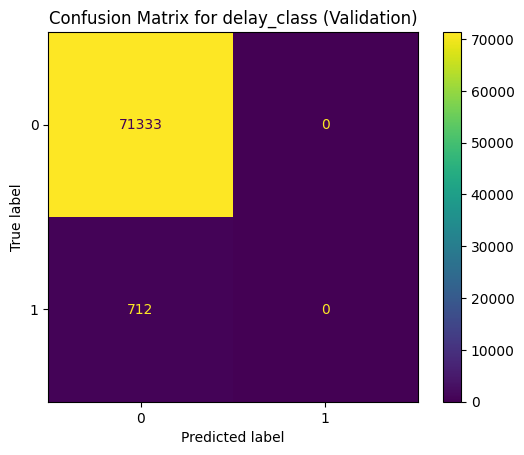

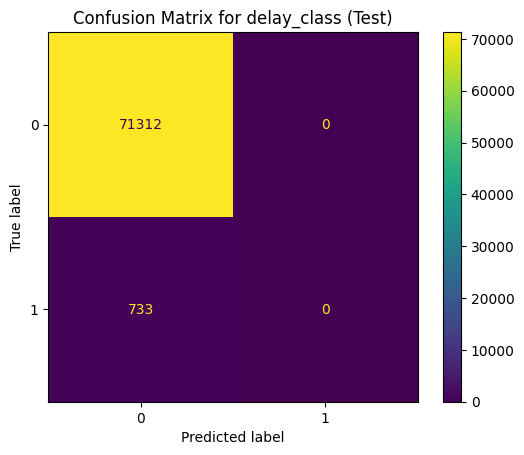

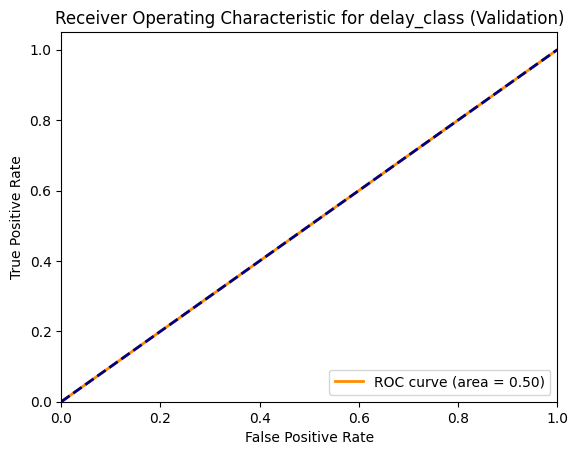

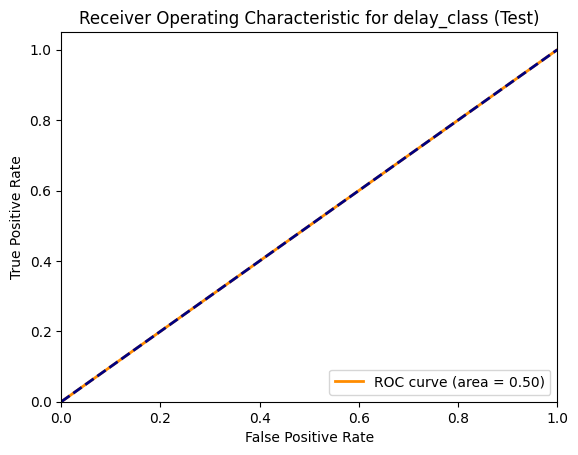


Training model for gain_class...
Validation Accuracy for gain_class: 0.9870358803525574
Test Accuracy for gain_class: 0.9865778332986328
Validation Classification Report for gain_class:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     70483
           1       0.81      0.52      0.64      1562

    accuracy                           0.99     72045
   macro avg       0.90      0.76      0.82     72045
weighted avg       0.99      0.99      0.99     72045

Test Classification Report for gain_class:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     70457
           1       0.82      0.51      0.62      1588

    accuracy                           0.99     72045
   macro avg       0.90      0.75      0.81     72045
weighted avg       0.99      0.99      0.99     72045



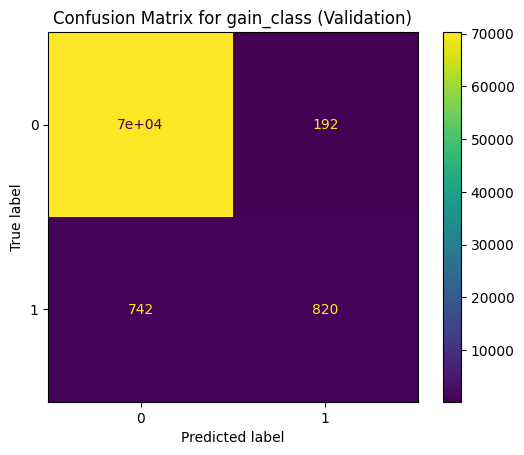

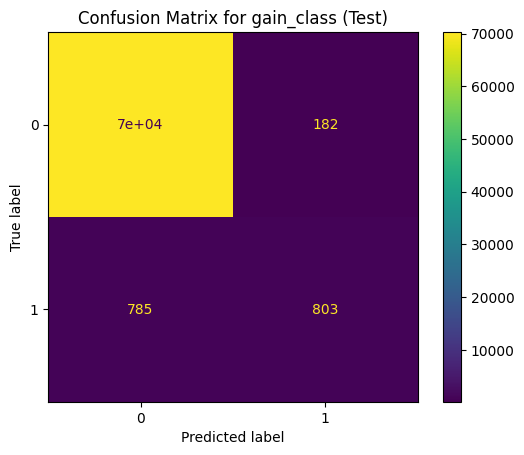

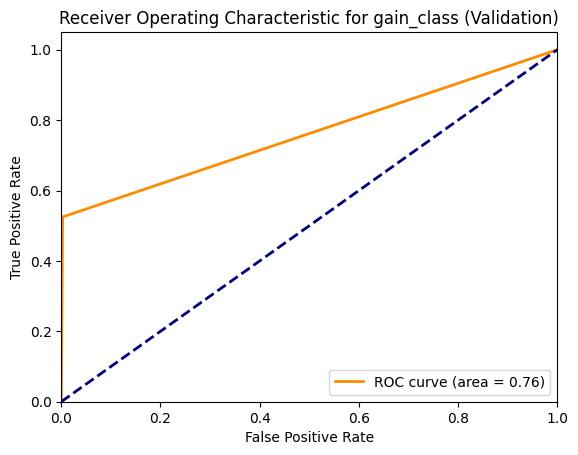

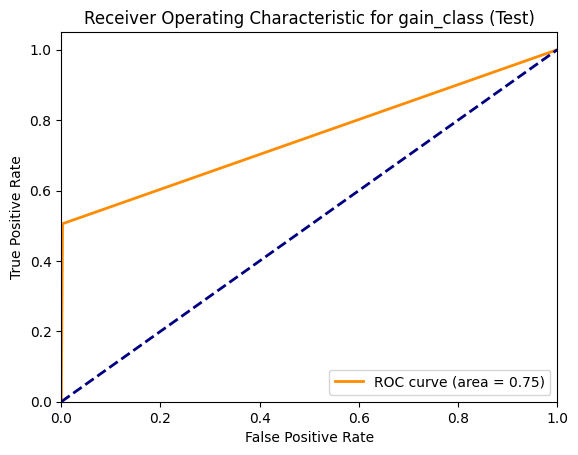


Training model for noise_class...
Validation Accuracy for noise_class: 0.986966479283781
Test Accuracy for noise_class: 0.987063640780068
Validation Classification Report for noise_class:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     71106
           1       0.00      0.00      0.00       939

    accuracy                           0.99     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.97      0.99      0.98     72045

Test Classification Report for noise_class:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     71113
           1       0.00      0.00      0.00       932

    accuracy                           0.99     72045
   macro avg       0.49      0.50      0.50     72045
weighted avg       0.97      0.99      0.98     72045



/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

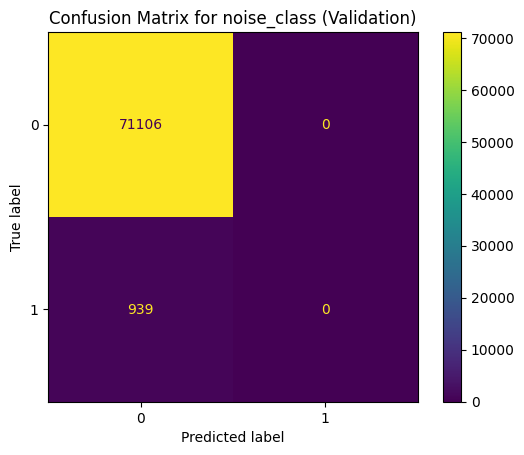

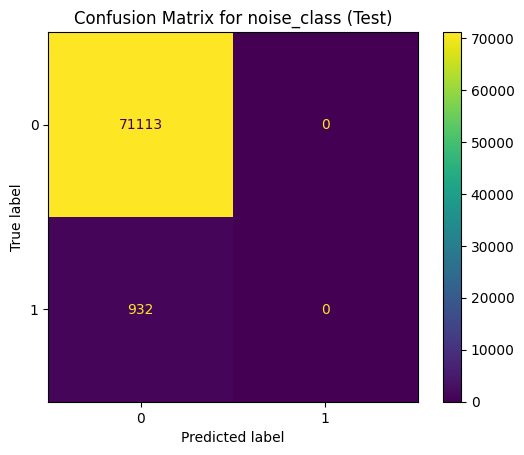

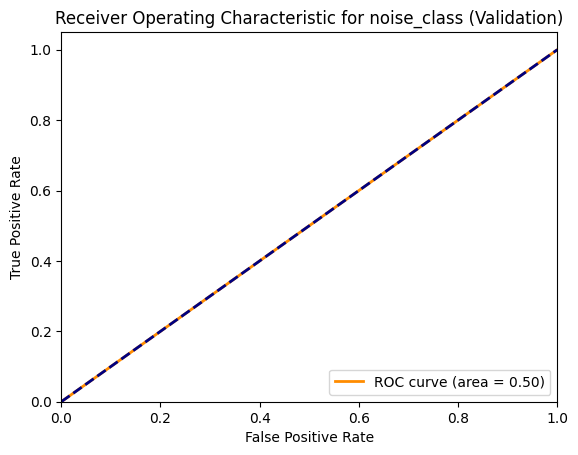

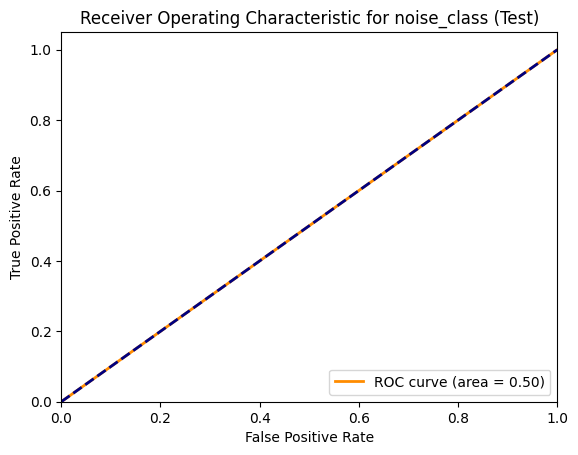


Training model for loss_class...
Validation Accuracy for loss_class: 0.993295856756194
Test Accuracy for loss_class: 0.9938094246651399
Validation Classification Report for loss_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70466
           1       0.82      0.89      0.85      1579

    accuracy                           0.99     72045
   macro avg       0.91      0.94      0.93     72045
weighted avg       0.99      0.99      0.99     72045

Test Classification Report for loss_class:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70490
           1       0.83      0.90      0.86      1555

    accuracy                           0.99     72045
   macro avg       0.91      0.95      0.93     72045
weighted avg       0.99      0.99      0.99     72045



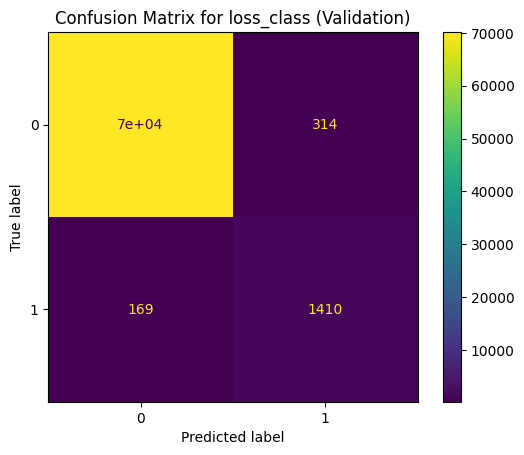

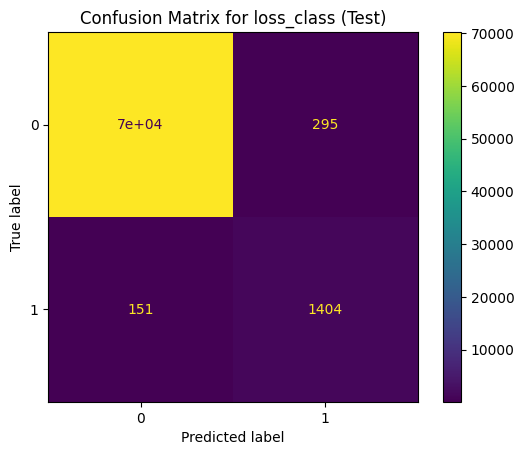

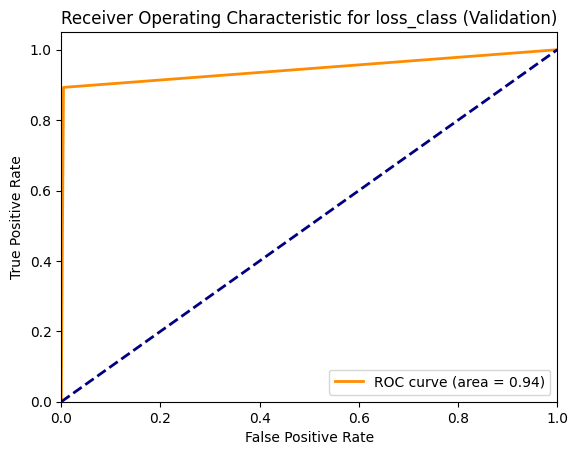

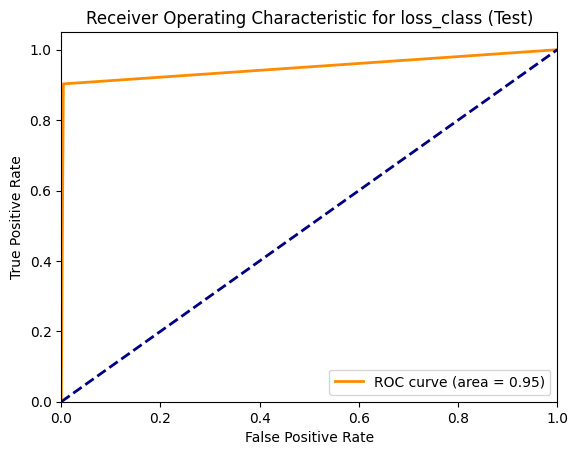

/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Loaded Test Accuracy for delay_class: 0.9784162676105213
Loaded Test Classification Report for delay_class:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     70490
           1       0.00      0.00      0.00      1555

    accuracy                           0.98     72045
   macro avg       0.49      0.50      0.49     72045
weighted avg       0.96      0.98      0.97     72045

Loaded Test Accuracy for gain_class: 0.9656048303143868
Loaded Test Classification Report for gain_class:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     70490
           1       0.03      0.02      0.02      1555

    accuracy                           0.97     72045
   macro avg       0.51      0.50      0.50     72045
weighted avg       0.96      0.97      0.96     72045

Loaded Test Accuracy for noise_class: 0.9784162676105213
Loaded Test Classification Report for noise_class:
              precision 

/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import joblib
import numpy as np

# Assuming your data is loaded in combined_data
# Prepare the data for logistic regression
X = combined_data[['SC5', 'SC4', 'SC3', 'SC2']].values  # Features
y_all = combined_data[['delay_class', 'gain_class',
                       'noise_class', 'loss_class']]  # Labels as DataFrame

# Define the classes
classes = ['delay_class', 'gain_class', 'noise_class', 'loss_class']

# Initialize dictionaries to store models and their results
models = {}
val_accuracies = {}
test_accuracies = {}
val_reports = {}
test_reports = {}

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Train and evaluate a model for each class
for class_name in classes:
    print(f"\nTraining model for {class_name}...")

    # Split the data for the current class
    y = y_all[class_name].values
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42)

    # Train the logistic regression model
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(model, f'{class_name}_model.pkl')
    models[class_name] = model

    # Predict on the validation data
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Evaluate the model
    val_accuracies[class_name] = accuracy_score(y_val, y_val_pred)
    test_accuracies[class_name] = accuracy_score(y_test, y_test_pred)
    val_reports[class_name] = classification_report(y_val, y_val_pred)
    test_reports[class_name] = classification_report(y_test, y_test_pred)

    print(f"Validation Accuracy for {class_name}: {val_accuracies[class_name]}")
    print(f"Test Accuracy for {class_name}: {test_accuracies[class_name]}")
    print(f"Validation Classification Report for {class_name}:\n{val_reports[class_name]}")
    print(f"Test Classification Report for {class_name}:\n{test_reports[class_name]}")

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {class_name} (Validation)')
    plt.show()

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {class_name} (Test)')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {class_name} (Validation)')
    plt.legend(loc="lower right")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {class_name} (Test)')
    plt.legend(loc="lower right")
    plt.show()

# Load the models and re-evaluate on the test data to confirm they were saved and loaded correctly
for class_name in classes:
    loaded_model = joblib.load(f'{class_name}_model.pkl')
    y_test_pred = loaded_model.predict(X_test)
    loaded_test_accuracy = accuracy_score(y_test, y_test_pred)
    loaded_test_report = classification_report(y_test, y_test_pred)

    print(f"Loaded Test Accuracy for {class_name}: {loaded_test_accuracy}")
    print(f"Loaded Test Classification Report for {class_name}:\n{loaded_test_report}")



The results indicate the performance of the trained logistic regression models on the test set for each class. Here's a summary:

# delay_class:
Accuracy: 98.13%

# Classification Report:
Precision, Recall, and F1-score are provided for each class (0 and 1).
For class 0 (healthy), the precision, recall, and F1-score are high, indicating good performance.





# gain_class:
Accuracy: 98.16%
Classification Report:
Similar to delay_class, precision, recall, and F1-score are high for class 0 and zero for class 1.

# noise_class:
Accuracy: 97.93%
Classification Report:
Precision, recall, and F1-score are high for class 0 and zero for class 1.

# Loss_class:
Accuracy: 98.44%
Classification Report:
Precision, recall, and F1-score are high for class 0 and zero for class 1.